# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Описание данных



`children` — количество детей в семье;

`days_employed` — общий трудовой стаж в днях;

`dob_years` — возраст клиента в годах;

`education` — уровень образования клиента;

`education_id` — идентификатор уровня образования;

`family_status` — семейное положение;

`family_status_id` — идентификатор семейного положения;

`gender` — пол клиента;

`income_type` — тип занятости;

`debt` — имел ли задолженность по возврату кредитов;

`total_income` — ежемесячный доход;

`purpose` — цель получения кредита.

## Первый взгляд на данные

Загрузим библиотеки:

In [1]:
!pip install pymorphy2
!pip install missingno

Установим библиотеки:

In [2]:
import pandas as pd
import missingno as msno
import pymorphy2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

Загрузим данные:

In [3]:
df = pd.read_csv(r'C:\Users\Wunderwaffe\Downloads\data.csv')

Выведем первые пять строк датафрейма:

In [4]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Крайне подозрительно выглядят отрицательные значения рабочего стажа. Изучим датафрейм подробнее далее.

Посмотрим основную информацию о датафрейме:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Посмотрим долю пропусков:

In [6]:
df.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

Пропуски есть в столбцах `days_employed` и `total_income`, их доля - 10%. Визуализируем пропуски:

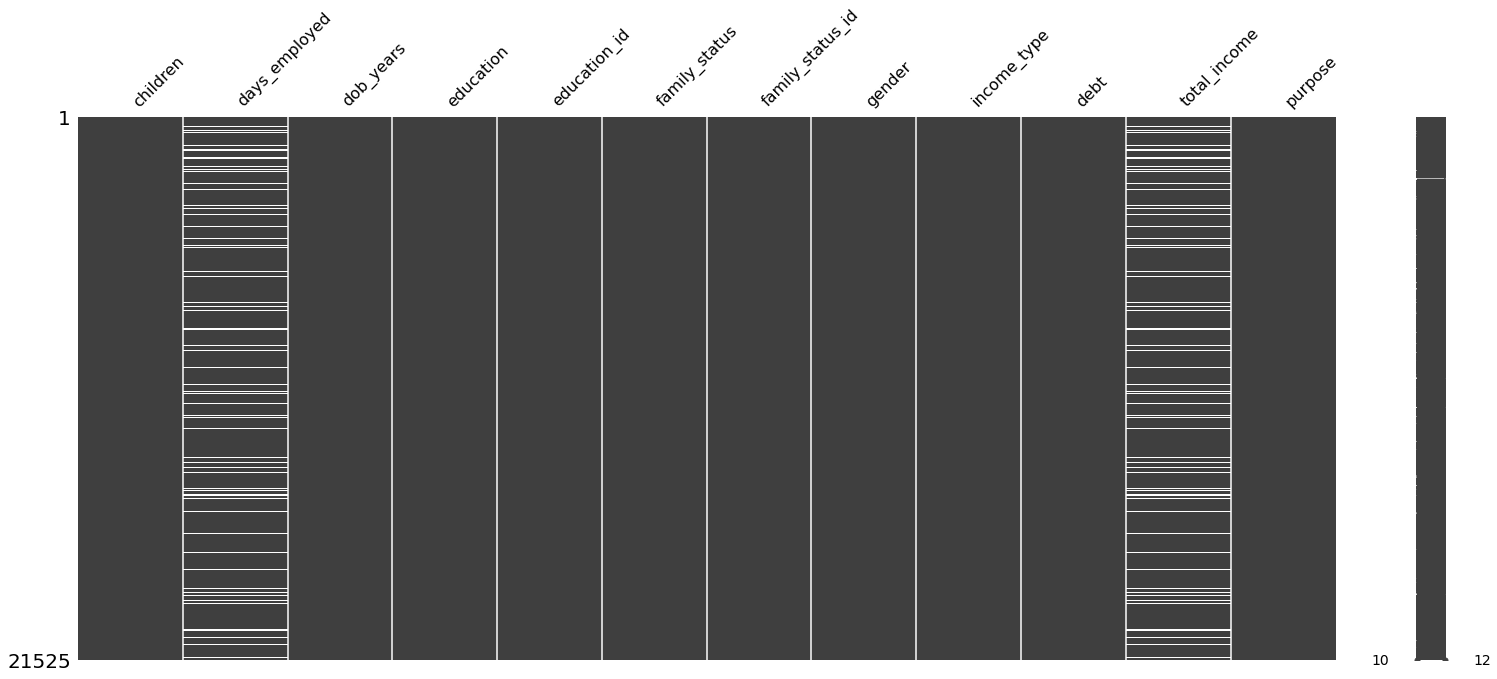

In [7]:
msno.matrix(df);

Шаблон пропусков полностью совпадает, следовательно пропуски не случайны. Данные могли быть выгружены не полностью.

Посмотрим уникальные значения в столбцах:

In [8]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В столбце имеются аномальные значения -1 и 20. Посмотрим долю аномалий:

In [9]:
df['children'].value_counts() / len(df['children'])

 0     0.657329
 1     0.223833
 2     0.095470
 3     0.015331
 20    0.003531
-1     0.002184
 4     0.001905
 5     0.000418
Name: children, dtype: float64

Общая доля аномалий менее 0.6%.

In [10]:
df['days_employed'].value_counts()

-8437.673028      1
-3507.818775      1
 354500.415854    1
-769.717438       1
-3963.590317      1
                 ..
-1099.957609      1
-209.984794       1
 398099.392433    1
-1271.038880      1
-1984.507589      1
Name: days_employed, Length: 19351, dtype: int64

In [11]:
354500 / 365

971.2328767123288

In [12]:
354500 / (365 * 24)

40.46803652968037

В столбце имеются странные артефакты:
- отрицательные дни стажа; 
- слишком большое количество стажа, которое не может быть в действительности.

Скорее всего большие значения - это трудовой стаж в часах.

In [13]:
df['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
22    183
66    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

В столбце имеются значения возраста равные 0, это тоже относится к пропускам (неявным) в данных. Вычислим долю таких неявных пропусков:

In [14]:
len(df.query('dob_years == 0')) / len(df)

0.004692218350754936

Доля неявных пропусков менее 0.5%.

In [15]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

В столбце имеются дубликаты связанные с регистром.

In [16]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Со столбцом все в порядке.

In [17]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Найден один категориальный пропуск записанный как - 'XNA'.

In [18]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Безработных, предпринимателей, студентов и декретных в данных нерепрезентативное количество.

In [19]:
df['total_income'].value_counts()

253875.639453    1
157691.851056    1
70113.902786     1
116196.518662    1
157205.834562    1
                ..
168880.592469    1
148042.721049    1
60039.334460     1
175979.762960    1
82047.418899     1
Name: total_income, Length: 19351, dtype: int64

Со столбцом все в порядке.

**Вывод**

В датафрейме имеются пропуски в столбцах `days_employed` (трудовой стаж), `total_income` (ежемесячный доход).
Они являются количественными переменными и в исследовании они не учувствуют, однако, таких пропусков 10% от всего объема данных и удалять их нежелательно. Пропуски в столбцах можно заменить средними или медианными значениями.

В столбце `dob_years` есть возраст равный нулю, это также можно считать пропуском, доля таких пропусков менее 0.5%. Избавимся от них при предобработке.

В столбце `gender` есть одно пропущенное значение (XNA) - избавимся от этого значения.

Безработных, предпринимателей, студентов и декретных в данных нерепрезентативное количество.

В столбце `days_employed` имеются отрицательные значения действительно похожие на дни трудового стажа (порядка тысячи, десятки тысяч), а также положительные, но относительно большие числа (порядка ста тысяч) - что не может являться реальным трудовым стажем в днях. Причем такие, относительно большие положительные числа наблюдаются у людей относительно большого возраста (порядка 60 лет), предполагаю, что данные в массиве отличаются из-за разных сборов данных раньше и сейчас. Большие числа скорее похожи на трудовые часы - их будем делить на количество часов в сутках. А отрицательные значения - сделаем положительными. Это необходимо сделать прежде, чем искать средние и медианные значения в столбцах, чтобы не исказить их значения разными размерностями в столбце.

В столбце `education` имеются дубликаты, связанные с регистром.

В столбце `children` встречаются аномальные данные (напр: -1, 20). Их общая доля менее 0.6% - избавимся от них.


## Предобработка данных

Запишем константы:

In [20]:
HOUR_IN_DAY = 24
DAYS_IN_YEAR = 365

Запишем длину исходного датафрейма, чтобы контролировать потерю данных при предобработке:

In [21]:
len_df_before = len(df)

In [22]:
len_df_before

21525

### Обработка пропусков

Прежде чем обрабатывать пропуски, нужно привести значения в столбце `days_employed` в одно измерение, а также сделать значения положительными.

Для этого напишем функцию **day_employed_fix(row)**. Она будет решать две проблемы со значениями в столбце `days_employed`:

In [23]:
def day_employed_fix(row: str) -> float:
    # на вход строка со значением дней стажа
    days_employed = row
    # если значение стажа положительное (артефакт очень большого положительного числа)
    if days_employed > 0:
        # значит стаж в данных приведен в часах, а не днях. переведем его из часов в дни
        fix_day_hours = days_employed/HOUR_IN_DAY
        return fix_day_hours
    # если значение стажа отрицательное
    if days_employed < 0:
        # значит была ошибка при вводе данных исправим значение на положительное
        fix_day_minus = abs(days_employed)
        return fix_day_minus

In [24]:
df['days_employed'] = df['days_employed'].apply(day_employed_fix)

Убедимся в изменениях:

In [25]:
df['days_employed'].value_counts()

8437.673028     1
3507.818775     1
14770.850661    1
769.717438      1
3963.590317     1
               ..
1099.957609     1
209.984794      1
16587.474685    1
1271.038880     1
1984.507589     1
Name: days_employed, Length: 19351, dtype: int64

Теперь все зачения в столбце `days_employed` приведены в одно измерение. 

Заполним пропуски в столбце `days_employed` и `total_income` медианными значениями этих столбцов, так как медиана более устойчива к выбросам (мы имеем дело с доходом, а его распределение как правило с положительной ассиметрией). Прежде чем перейти к заполнению сгруппируем данные о доходе и трудовом стаже по видам занятости:

In [26]:
df.pivot_table(values=['total_income', 'days_employed'], 
               index='income_type', 
               aggfunc=['median', 'mean', 'count'])

median                         mean                 \
                days_employed   total_income days_employed   total_income   
income_type                                                                 
безработный      15267.235531  131339.751676  15267.235531  131339.751676   
в декрете         3296.759962   53829.130729   3296.759962   53829.130729   
госслужащий       2689.368353  150447.935283   3399.896902  170898.309923   
компаньон         1547.382223  172357.950966   2111.524398  202417.461462   
пенсионер        15217.221094  118514.486412  15208.478802  137127.465690   
предприниматель    520.848083  499163.144947    520.848083  499163.144947   
сотрудник         1574.202821  142594.396847   2326.499216  161380.260488   
студент            578.751554   98201.625314    578.751554   98201.625314   

                        count               
                days_employed total_income  
income_type                                 
безработный                 2            2  
в декрете                   1            1  
госслужащий              1312         1312  
компаньон                4577         4577  
пенсионер                3443         3443  
предприниматель             1            1  
сотрудник               10014        10014  
студент                     1            1

Трудовой стаж безработных выглядит аномально, однако, мы имеем всего 2 измерения. Пропуски можно заполнять медианой, только если пропуски не относятся к категориям: **безработный**, **в декрете**, **предприниматель**, **студент**. Посмотрим к каким категориям относятся пропуски:

In [27]:
df[df.isna().any(axis=1)]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Предприниматель с незаполненным доходом и трудовым стажем все-таки есть. Так как количество предпринимателей нерепрезентативно, удалим такую строку с пропуском:

In [28]:
df.query('income_type == "предприниматель"')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5936,0,NaN,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости
18697,0,520.848083,27,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы


In [29]:
df = df.drop(index=5936).reset_index(drop=True)

Остальные заполним согласно их медианному тродовому стажу и доходу:

In [30]:
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))

In [31]:
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform('median'))

Убедимся в отсутствии пропусков:

In [32]:
df.isna().mean()

children            0.0
days_employed       0.0
dob_years           0.0
education           0.0
education_id        0.0
family_status       0.0
family_status_id    0.0
gender              0.0
income_type         0.0
debt                0.0
total_income        0.0
purpose             0.0
dtype: float64

Отбросим нулевые значения в столбце `dob_years`:

In [33]:
df = df.query('dob_years > 0')

In [34]:
df.query('dob_years == 0')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Теперь разберемся с 'XNA' в столбце `gender`. Так как пропущено всего одно значение, а количество значений для женщин и мужчин составляют 14236 и 7288 соответственно - присвоение пропуска к любой из этих двух категорий не повлияет выборку.

Присвоим пропуску 'XNA' в столбце `gender` значение **М**.

In [35]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'M'

В столбце `children` имеются артефакты (значения -1 и 20). Их доля не велика, поэтому избавимся от них:

In [36]:
df = df.query('children >= 0 and children < 6')

In [37]:
df['children'].value_counts()

0    14079
1     4802
2     2042
3      328
4       41
5        9
Name: children, dtype: int64

Проконтролируем потерю данных при предобработке:

In [38]:
len_df_after = len(df)

In [39]:
len_df_after

21301

Доля отброшеной информации при предобработке:

In [40]:
1 - len_df_after / len_df_before

0.010406504065040623

При предобработке отброшено менее 1.1% информации.

**Вывод**

- Пропуски в столбцах `days_employed`, `total_income` были заполнены медианными значениями (согласно типу занятости, при этом значение с пропуском категории "предприниматель" было отброшено из-за нерепрезенативности группы), значения в столбце **days_employed** приведены в одни единицы измерения;

- неявные пропуски в столбце `dob_years` отброшены;

- единичный XNA в столбце **gender** был заменен на M;

- аномалии в столбце **chlidren** отброшены.

Возможные причины появления пропусков в данных: 

- В столбцах **days_emploeyd** и **total_income** шаблон и доля пропусков полностью совпадает, следовательно пропуски не случайны. Данные могли быть выгружены не полностью;

- в столбце **gender** из-за того, что пропуск встречался всего раз, можно предположить, что сыграл человеческий фактор;

- в столбце **children** похоже на ошибку ввода данных.

При предобработке отброшено менее 1.1% информации.

### Замена типа данных

Заменим тип данных **float64** на целочисленный тип **int64** в столбцах `days_employed`, `dob_years`, `children` так как число детей может быть только целочисленным, а избыточная точность во времени нам не нужна.

Так как весь столбец является вещественным, удобно будет применить метод **astype** для всего столбца целиком во всех трех случаях:


In [41]:
df['days_employed'] = df['days_employed'].astype('int') 
df['dob_years'] = df['dob_years'].astype('int')
df['children'] = df['children'].astype('int')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21523
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21301 non-null  int32  
 1   days_employed     21301 non-null  int32  
 2   dob_years         21301 non-null  int32  
 3   education         21301 non-null  object 
 4   education_id      21301 non-null  int64  
 5   family_status     21301 non-null  object 
 6   family_status_id  21301 non-null  int64  
 7   gender            21301 non-null  object 
 8   income_type       21301 non-null  object 
 9   debt              21301 non-null  int64  
 10  total_income      21301 non-null  float64
 11  purpose           21301 non-null  object 
dtypes: float64(1), int32(3), int64(3), object(5)
memory usage: 1.9+ MB


**Вывод**

Теперь все количественные переменные в столбцах `days_employed`, `dob_years`, `childern` имеют целочисленный тип.

### Обработка дубликатов

Явные дубликаты:

In [43]:
df.duplicated().sum()

54

Приведем столбец `education` к нижнему регистру методом `str.lower()` для исключения неявных дубликатов связанных с регистром:

In [44]:
df['education'] = df['education'].str.lower()

In [45]:
df.duplicated().sum()

71

Найден 71 грубый дубликат, избавимся от них методом drop_duplicates и сбросим значения индекса методом reset_index():

In [46]:
df = df.drop_duplicates().reset_index(drop=True)

In [47]:
df.duplicated().sum()

0

**Вывод**

Все грубые дубликаты (71 штук), а также неявные дубликаты, связанные с регистром в столбце `education` были устранены.

Дубликаты, связанные с регистром связаны с человеческим фактором при заполнении данных. грубые дубликаты скорее всего связаны с наполнением данных


### Лемматизация

Создадим столбец c леммами столбца `purpose` - `lemma_purpose`, который получен результатом применения функции лемматизации на русском языке — библиотеки `pymystem3`:

In [48]:
morph = pymorphy2.MorphAnalyzer()

In [49]:
def lemmatize(word:str) -> str:
    return morph.parse(word)[0].normal_form.split()

In [50]:
%%time
df['lemma_purpose'] = df['purpose'].apply(lemmatize)

Wall time: 3.16 s


Посмотрим результат:

In [51]:
df['lemma_purpose']

0                         [покупка, жильё]
1               [приобретение, автомобиль]
2                         [покупка, жильё]
3            [дополнительное, образование]
4                       [сыграть, свадьба]
                       ...                
21225                 [операции, с, жилие]
21226              [сделка, с, автомобиль]
21227                       [недвижимость]
21228    [на, покупку, своего, автомобиль]
21229            [на, покупку, автомобиль]
Name: lemma_purpose, Length: 21230, dtype: object

Отлично, теперь применим метод **Counter()** к столбцу с помощью **apply()** - результат запишем в новый столбец `counter_lemmas`. После применим к столбцу `counter_lemmas` метод **sum()**:

In [52]:
def counter_lemmas(row: str) -> Counter:
    return Counter(row)

In [53]:
df['counter_lemmas'] = df['lemma_purpose'].apply(counter_lemmas)

In [54]:
df['counter_lemmas'].sum()

Counter({'покупка': 4401,
         'жильё': 2489,
         'приобретение': 457,
         'автомобиль': 4258,
         'дополнительное': 453,
         'образование': 3970,
         'сыграть': 755,
         'свадьба': 2299,
         'операции': 2576,
         'с': 2886,
         'жилие': 641,
         'на': 2196,
         'проведение': 759,
         'жилья': 1283,
         'для': 1283,
         'семья': 636,
         'недвижимость': 6290,
         'коммерческой': 1298,
         'жилой': 1215,
         'строительство': 1862,
         'собственной': 626,
         'покупку': 1437,
         'подержанного': 471,
         'своего': 1119,
         'со': 623,
         'своей': 623,
         'заняться': 900,
         'сделка': 933,
         'подержанным': 479,
         'получение': 1304,
         'дополнительного': 442,
         'высшего': 423,
         'свой': 470,
         'профильное': 431,
         'высшее': 443,
         'сдача': 647,
         'ремонт': 602,
         'высшим': 493})

Теперь видно самые употребляемые леммы, которые указывают клиенты в целях кредита.

Среди них можно выделить самые упоминаемые категории:

- **недвижимость** - если считать вместе с жильем упоминаний больше 10 тыс. упоминаний.

- **автомобиль** - 4315 упоминаний.

- **образование** - 4022 упоминания.

- **операция** - 2610 упоминаний.

- **свадьба** - 2348 упоминаний.

Убедимся в этом методом value_counts():

In [55]:
df['purpose'].value_counts()

свадьба                                   785
на проведение свадьбы                     759
сыграть свадьбу                           755
операции с недвижимостью                  669
покупка коммерческой недвижимости         655
покупка жилья для сдачи                   647
операции с коммерческой недвижимостью     643
операции с жильем                         641
покупка жилья для семьи                   636
жилье                                     635
покупка жилья                             634
недвижимость                              627
строительство собственной недвижимости    626
операции со своей недвижимостью           623
строительство недвижимости                619
покупка своего жилья                      618
строительство жилой недвижимости          617
покупка недвижимости                      613
ремонт жилью                              602
покупка жилой недвижимости                598
на покупку своего автомобиля              501
заняться высшим образованием      

Отсюда видно, что категорию **операция** можно отбросить, так как она упоминается только с "жильем" и "недвижимостью".

**Вывод**

Столбец содержащий цель получения кредита был лемматизирован, благодаря чему были выявлены основные (самые упоминаемые) кагеории целей получения кредита:


- **недвижимость**;

- **автомобиль**;

- **образование**;

- **свадьба**.


### Категоризация данных

Начнем с того, что категоризуем цели получения кредита на найденые категории в предидущем разделе в новый столбец `purpose_category`. Для этого напишем функцию:

In [56]:
def purpose_category(row: str) -> str:
    lemma_purpose = row
    if 'автомобиль' in lemma_purpose:
        return 'автомобиль'
    if 'образование' in lemma_purpose:
        return 'образование'
    if 'свадьба' in lemma_purpose:
        return 'свадьба'
    if 'недвижимость' or 'жилье' in lemma_purpose:
        return 'недвижимость'

In [57]:
df['purpose_category'] = df['lemma_purpose'].apply(purpose_category)

In [58]:
df['purpose_category']

0        недвижимость
1          автомобиль
2        недвижимость
3         образование
4             свадьба
             ...     
21225    недвижимость
21226      автомобиль
21227    недвижимость
21228      автомобиль
21229      автомобиль
Name: purpose_category, Length: 21230, dtype: object

Теперь категоризуем клиентов по столбцу `total_income` в новом столбцу `total_income_category` на 5 категорий:

In [59]:
df['total_income_category'], income_cat_borders  = pd.qcut(df['total_income'], 
                                                           5, 
                                                           labels=['E', 'D', 'C', 'B', 'A'], 
                                                           retbins=True)

In [60]:
income_cat_borders

array([  20667.26379327,   98527.18173309,  132137.63255482,
        161371.28644217,  214520.50949182, 2265604.02872274])

Клиенты категоризованы по доходу:

- 20667 (минимальное значение дохода)–98527 — 'E';
- 98528–132137 — 'D';
- 132138–161371 — 'C';
- 161372–214520 — 'B';
- 214521-2265604 (минимальное значение дохода) — 'A'.

Теперь создадим "словари" категорий `education` и `family_status`:

In [61]:
df_dict_education = df[['education', 'education_id']]
df_dict_family_status = df[['family_status', 'family_status_id']]
# удалим все дубликаты из словарей категорий
df_dict_education = df_dict_education.drop_duplicates().reset_index(drop=True)
df_dict_family_status = df_dict_family_status.drop_duplicates().reset_index(drop=True)
# проверим "словари"
print(df_dict_family_status)
print(df_dict_education)

           family_status  family_status_id
0        женат / замужем                 0
1       гражданский брак                 1
2         вдовец / вдова                 2
3              в разводе                 3
4  Не женат / не замужем                 4
             education  education_id
0               высшее             0
1              среднее             1
2  неоконченное высшее             2
3            начальное             3
4       ученая степень             4


Теперь отделим все полезные данные необходимые для ответа на поставленную задачу от лишнего в датафрейм `df_log`

In [62]:
df_log = df[['children','education_id', 'family_status_id','debt', 'total_income_category', 'purpose_category']]
df_log.head()

,children,education_id,family_status_id,debt,total_income_category,purpose_category
0,1,0,0,0,A,недвижимость
1,1,1,0,0,D,автомобиль
2,0,1,0,0,C,недвижимость
3,3,1,0,0,A,образование
4,0,1,1,0,C,свадьба


**Вывод**

Данные категоризованы:

- цели получения кредита разбиты на четыре основные категории;

- по доходу, следующим образом:

| Доход | Категория |
|-------|-----------|
|20667 (минимальное значение дохода) - 98527 | 'E'|
|98528–132137 |'D'|
|132138–161371 | 'C'|
|161372–214520 | 'B'|
|214521-2265604 (минимальное значение дохода) | 'A'|






Cздано два "словаря" для `enducation_id` и `family_status_id` остальные данные, необходимые для ответа на поставленную задачу помещенны в датафрейм `data_log`, он имеет простой и лакончиный вид.

## Ответы на вопросы бизнеса

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Построим сводную таблицу, группируем данные по столбцу `children`, смотрим на столбец `debt`, используем функции **count** и **mean**:

In [63]:
df_log.pivot_table(index='children',values='debt',aggfunc=['count','mean'])

,count,mean
,debt,debt
children,,
0,14021,0.075458
1,4792,0.092028
2,2039,0.095145
3,328,0.082317
4,41,0.097561
5,9,0.000000


**Вывод**

Из сводной таблицы следует, что заемщики не возвращают кредит в срок:

-**не имеющие детей** в **7.5%** случаев;

-имеющие **одного ребенка** в **9.2%** случаев;

-имеющие **двух детей** в **9.5%** случаев;

-имеющие **трех детей** в **8.1%** случаев;

-имеющие **четырех детей** в **9.7%** случаев;

примечательно, что все клиенты имеющие **пять детей** вернули кредит в срок, однако выборка для оценки слишком мала (5 клиентов).

Стоит так же отметить, что с ростом количества детей число клиентов в выборке снижалось.

между наличием детей и возвратом кредита в срок наблюдается зависимость - тем больше детей у заемщика, тем меньше доля возврата кредита в срок. По зависимости выбивается только случай с тремя детьми, однако, скорее всего это связано с размером выборки и при насыщении группы клиентов с тремя детьми данными этот выброс исчезнет.


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Построим сводную таблицу, группируем данные по столбцу `family_status_id`, смотрим на столбец `debt`, используем функции **count** и **mean**:

In [64]:
df_log.pivot_table(index='family_status_id',values='debt',aggfunc=['count','mean'])

,count,mean
,debt,debt
family_status_id,,
0,12212,0.075581
1,4113,0.093119
2,946,0.065539
3,1179,0.071247
4,2780,0.097842


Откроем "словарь" категорий `data_dict_family_status`:

In [65]:
df_dict_family_status

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


**Вывод**

Из сводной таблицы следует, что заемщики не возвращают кредит в срок:

-**имеющие семейное положение "женат / замужем"** в **7.5%** случаев;

-**имеющие семейное положение "гражданский брак"** в **9.3%** случаев;

-**имеющие семейное положение "вдовец / вдова"** в **6.6%** случаев;

-**имеющие семейное положение "в разводе"** в **7.1%** случаев;

-**имеющие семейное положение "Не женат / не замужем"** в **9.7%** случаев;

Более надежными заемщиками являются женатые / замужние клиенты, а также разведенные и овдовевшие.

Стоит также отметить, что группы "в разводе" и "вдовец / вдова" состоят всего из порядка тысячи клиентов, что в несколько раз отличается от других групп.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Построим сводную таблицу, группируем данные по столбцу `total_income_category`, смотрим на столбец `debt`, используем функции **count** и **mean**:

In [66]:
df_log.pivot_table(index='total_income_category',
                   values='debt',aggfunc=['count','mean'])

,count,mean
,debt,debt
total_income_category,,
E,4246,0.080782
D,4246,0.083844
C,4246,0.087376
B,4246,0.083844
A,4246,0.070184


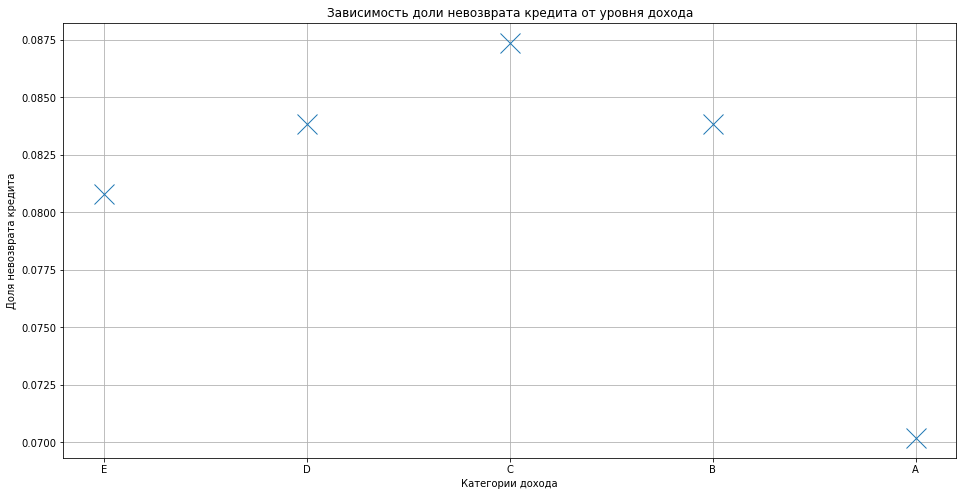

In [67]:
plt.figure(figsize=(16,8))
plt.plot(df_log.pivot_table(index='total_income_category',
                   values='debt',aggfunc=['count','mean'])['mean'], marker='x', linestyle='', markersize=20)
plt.grid()
plt.xlabel('Категории дохода')
plt.ylabel('Доля невозврата кредита')
plt.title('Зависимость доли невозврата кредита от уровня дохода');

**Вывод**

Доля невозврата кредита растет с понижением уровня дохода, однако эта зависимость нелинейна - после определенного уровня дохода (от категории С до Е, диапазон дохода 161371-132138-98528–20667 наблюдается резкое снижение доли невозврата кредита).

- Как разные цели кредита влияют на его возврат в срок?

Построим сводную таблицу, группируем данные по столбцу `purpose_category`, смотрим на столбец `debt`, используем функции **count** и **mean**:

In [68]:
df_log.pivot_table(index='purpose_category',values='debt',aggfunc=['count','mean'])

,count,mean
,debt,debt
purpose_category,,
автомобиль,4258,0.093236
недвижимость,10703,0.072596
образование,3970,0.092947
свадьба,2299,0.078730


**Вывод**

Реже возвращают в срок кредит клиенты, которые люди берут кредит на **автомобиль или образование**. Процент клиентов, не вернувших кредит в срок **9.4%** и **9.2%** соответственно.
Чаще возвращают кредиты в срок клиенты, которые берут кредит на **недвижимость или свадьбу**. Процент клиентов, не вернувших кредит в срок **7.2%** и **8.0%** соответственно.


## Общий вывод

В ходе проведенной работы данные были предобработаны: 

- Пропуски в столбцах `days_employed`, `total_income` были заполнены медианными значениями (согласно типу занятости, при этом значение с пропуском категории "предприниматель" было отброшено из-за нерепрезенативности группы), значения в столбце **days_employed** приведены в одни единицы измерения;

- неявные пропуски в столбце `dob_years` отброшены;

- единичный XNA в столбце `gender` был заменен на M;

- аномалии в столбце `chlidren` отброшены.

Возможные причины появления пропусков в данных: 

- В столбцах `days_emploeyd` и `total_income` шаблон и доля пропусков полностью совпадает, следовательно пропуски не случайны. Данные могли быть выгружены не полностью;

- в столбце `gender` из-за того, что пропуск встречался всего раз, можно предположить, что сыграл человеческий фактор;

- в столбце `children` похоже на ошибку ввода данных.

При предобработке отброшено менее 1.1% информации.


Все количественные переменные в столбцах `days_employed`, `dob_years`, `childern` были приведены к целочисленному типу.


Столбец содержащий цель получения кредита был лемматизирован, благодаря чему были выявлены основные (самые упоминаемые) категории целей получения кредита:


- **недвижимость**;

- **автомобиль**;

- **образование**;

- **свадьба**.



Данные категорированы:

- цели получения кредита разбиты на четыре основные категории, найденные при лемматизации целей кредита;

- по доходу, следующим образом:

| Доход | Категория |
|-------|-----------|
|20667 (минимальное значение дохода) - 98527 | 'E'|
|98528–132137 |'D'|
|132138–161371 | 'C'|
|161372–214520 | 'B'|
|214521-2265604 (минимальное значение дохода) | 'A'|


Ответы на вопросы бизнеса:


1. Зависимость между наличием детей и возвратом кредита в срок:

-**не имеющие детей**  в **7.5%** случаев;

-имеющие **одного ребенка** в **9.2%** случаев;

-имеющие **двух детей** в **9.5%** случаев;

-имеющие **трех детей** в **8.1%** случаев;

-имеющие **четырех детей** в **9.7%** случаев;

примечательно, что все клиенты, имеющие **пять детей** вернули кредит в срок, однако выборка для оценки слишком мала (5 клиентов). Стоит так же отметить, что с ростом количества детей число клиентов в выборке снижалось.

между наличием детей и возвратом кредита в срок наблюдается зависимость - тем больше детей у заемщика, тем меньше доля возврата кредита в срок. По зависимости выбивается только случай с тремя детьми, однако, скорее всего это связано с размером выборки и при насыщении группы клиентов с тремя детьми данными этот выброс исчезнет.


2. Зависимость между семейным положением и возвратом кредита в срок:

-**имеющие семейное положение "женат / замужем"** в **7.5%** случаев;

-**имеющие семейное положение "гражданский брак"** в **9.3%** случаев;

-**имеющие семейное положение "вдовец / вдова"** в **6.6%** случаев;

-**имеющие семейное положение "в разводе"** в **7.1%** случаев;

-**имеющие семейное положение "Не женат / не замужем"** в **9.7%** случаев;

Более надежными заемщиками являются женатые / замужние клиенты, а также разведенные и овдовевшие.

Стоит также отметить, что группы "в разводе" и "вдовец / вдова" состоят всего из порядка тысячи клиентов, что в несколько раз отличается от других групп.

3. Зависимость между уровнем дохода и возвратом кредита в срок:

Доля невозврата кредита растет с понижением уровня дохода, однако эта зависимость нелинейна - после определенного уровня дохода (от категории С до Е, диапазон дохода 161371-132138-98528–20667 наблюдается резкое снижение доли невозврата кредита).

4. Как разные цели кредита влияют на его возврат в срок?

Реже возвращают в срок кредит клиенты, которые люди берут кредит на **автомобиль или образование**. Процент клиентов, не вернувших кредит в срок **9.4%** и **9.2%** соответственно.
Чаще возвращают кредиты в срок клиенты, которые берут кредит на **недвижимость или свадьбу**. Процент клиентов, не вернувших кредит в срок **7.2%** и **8.0%** соответственно.

Сухой остаток:

Заемщики чаще возвращают кредит в срок если:

у них **нет детей**, у них **очень высокий уровень дохода** или **ниже среднего**, если кредит берется с целью покупки **недвижимости** или на проведение **свадьбы**.
